## Collecting Data
Working on converting scores on USAU tournament websites into a data table for analysis with pandas. Based on playing over 3 years of organized Ultimate Frisbee and inspecting the USAU website's score tables, I have a rough idea of what I'm looking for. The USAU tournament info is split into  slides/tabs for the pools and brackets. 

The pool play is under the section with `id="poolSlide"`. Then, the pools are organized under sections of `data-type="pool"` and organized into tables of `class="scores_table"`. Each game is under its own table row with a `data-game` identifier.

Bracket play is under the section with `id="bracketSlide"` and set up in a rather unique way because they try to make it look like the bracket.

In [1]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt

In [2]:
USER_AGENT = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36"
# US english
LANGUAGE = "en-US,en;q=0.5"

def get_soup(url):
    """Constructs and returns a soup using the HTML content of `url` passed"""
    # initialize a session
    session = requests.Session()
    # set the User-Agent as a regular browser
    session.headers['User-Agent'] = USER_AGENT
    # request for english content (optional)
    session.headers['Accept-Language'] = LANGUAGE
    session.headers['Content-Language'] = LANGUAGE
    # make the request
    html = session.get(url)
    # return the soup
    return bs(html.content, "html.parser")

In [6]:
def get_all_scoretables(soup):
    """Extracts and returns all tables in a soup object"""
    return soup.find_all("table",class_="scores_table")

def get_scoretable_name(table):
    """Given a table soup, returns the table's name"""
    return table.find("thead").find("tr").find("th").text.strip()

def get_table_headers(table):
    """Given a table soup, returns all the headers"""
    headers = []
    for th in table.find("tbody").find("tr").find_all("th"):
        headers.append(th.text.strip())
    return headers

def get_table_rows(table):
    """Given a table, returns all its rows"""
    rows = []
    for tr in table.find("tbody").find_all("tr")[1:]:
        cells = []
        # grab all td tags in this table row
        tds = tr.find_all("td")
        if len(tds) == 0:
            # if no td tags, search for th tags
            # can be found especially in wikipedia tables below the table
            ths = tr.find_all("th")
            for th in ths:
                cells.append(th.text.strip())
        else:
            # use regular td tags
            for td in tds:
                cells.append(td.text.strip())
        rows.append(cells)
    return rows
#Shout out to https://www.thepythoncode.com/article/convert-html-tables-into-csv-files-in-python.

def scrape_and_clean_scoretables(base_url, event):
    #scrape
    soup = get_soup(base_url+event)
    tables = get_all_scoretables(soup)
    T = len(tables)
    print(f"Found {T} score tables")
    #clean
    frames = []
    for i, table in enumerate(tables, start=1):
        headers = get_table_headers(table)
        rows = get_table_rows(table)
        df = pd.DataFrame(rows, columns=headers)
        df['table'] = get_scoretable_name(table)
        df['event'] = event
        df['home_score'] = df['Score'].str.extract(r'(^\d+)').astype(int)
        df['away_score'] = df['Score'].str.extract(r'(\d+$)').astype(int)
        df = df[['event','table','Date','Time','Team 1','Team 2','home_score','away_score']]
        frames.append(df)
    result = pd.concat(frames)
    headers = ['event','table','Date','Time','home_team','away_team','home_score','away_score']
    result.columns = headers
    return result

def scrape_and_clean_brackets(base_url, event):
    #scrape
    soup = get_soup(base_url+event)
    bracketgames = soup.find_all("div",{"class":"bracket_game"})
    print(f"Found {len(bracketgames)} bracket games")
    #clean
    games = []
    for i, game in enumerate(bracketgames):
        game_id = game['id']
        home_team = game.find("span",{"class":"team","data-type":"game-team-home"}).text
        away_team = game.find("span",{"class":"team","data-type":"game-team-away"}).text
        home_score = game.find("span",{"class":"score","data-type":"game-score-home"}).text
        away_score = game.find("span",{"class":"score","data-type":"game-score-away"}).text
        game_time = game.find("span",{"class":"date"}).text
        games.append([event,game_id,game_time,home_team,away_team,home_score,away_score])
    headers = ['event','game_id','game_time','home_team','away_team','home_score','away_score']
    result = pd.DataFrame(games,columns=headers)
    return result

**Let's get our data!**

In [7]:
BASE_URL = "https://play.usaultimate.org/events/"
EVENT = "Florida-Warm-Up-2019/schedule/Men/CollegeMen/"
FILE_PATH = f"./data/ultimate/{EVENT}"
if not os.path.exists(FILE_PATH):
    os.makedirs(FILE_PATH)
print(f"Data files will be stored under {FILE_PATH}")

Data files will be stored under ./data/ultimate/Florida-Warm-Up-2019/schedule/Men/CollegeMen/


In [8]:
poolplay = scrape_and_clean_scoretables(BASE_URL,EVENT)
poolplay.to_csv(f"{FILE_PATH}poolplay.csv")
bracketplay = scrape_and_clean_brackets(BASE_URL, EVENT)
bracketplay.to_csv(f"{FILE_PATH}bracketplay.csv")

Found 3 score tables
Found 56 bracket games


Now that we have our data in a nice format, we can start doing some analysis...
Let's start by looking at a team's goal differential at a tournament

In [9]:
poolplay['home_diff'] = poolplay['home_score'] - poolplay['away_score']
poolplay['away_diff'] = poolplay['away_score'] - poolplay['home_score']
bracketplay['home_diff'] = bracketplay['home_score'].astype(int) - bracketplay['away_score'].astype(int)
bracketplay['away_diff'] = bracketplay['away_score'].astype(int) - bracketplay['home_score'].astype(int)

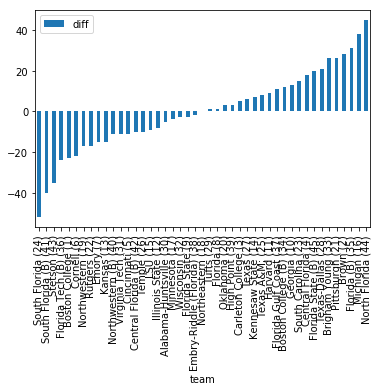

In [11]:
home = poolplay[['home_team','home_diff']]
home.columns = ['team','diff']
away = poolplay[['away_team','away_diff']]
away.columns = ['team','diff']
merged = home.append(away,ignore_index=True)
merged.groupby('team').sum().sort_values(by='diff').plot(kind='bar')

But that's only from the pool play games

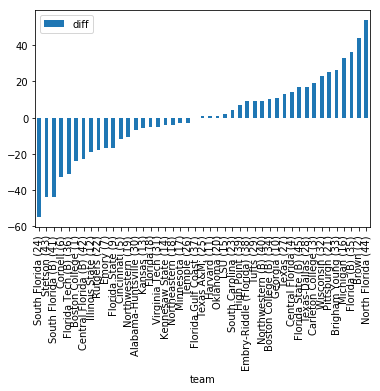

In [12]:
bracket_home = bracketplay[['home_team','home_diff']]
bracket_home.columns = ['team','diff']
merged = merged.append(bracket_home,ignore_index=True)
bracket_away = bracketplay[['away_team','away_diff']]
bracket_away.columns = ['team','diff']
merged = merged.append(bracket_away,ignore_index=True)
merged.groupby('team').sum().sort_values(by='diff').plot(kind='bar')

## Ranking Teams
(see [this link](https://play.usaultimate.org/teams/events/rankings/) for full, official details)

Let's take a look at the USAU ranking system. At its simplest level, each game outcome results in a rating for each playing team. Then, those ratings are averaged over all games played by each team.

First, we must ask: how do you compute rating points for individual games?
Second, we must ask: how do you average the ratings?



The general formula for computing an individual games' rating points is:
$$\text{Rating Differential: } d=125+475\frac{\sin(\min(1,\frac{1-r}{0.5})\cdot 0.4\pi)}{\sin(0.4\pi)},$$
$$\text{where: } r= \frac{\text{losing score}}{\text{winning score}-1}.$$

So let's take a look at how that works.

In [22]:
import math

def calculate_ratings(df):
    rate_diff = []
    for index, game in df.iterrows():
        winning_score = max(game['home_score'],game['away_score'])
        losing_score = min(game['home_score'],game['away_score'])
        r = losing_score/(winning_score-1)
        d = 125 + 475*(math.sin(min(1,(1-r)/0.5)*.4*math.pi)/math.sin(.4*math.pi))
        rate_diff.append(d)
    df['rate_diff'] = rate_diff

In [24]:
calculate_ratings(poolplay)
poolplay[['home_team','away_team','home_score','away_score','rate_diff']].head()

,home_team,away_team,home_score,away_score,rate_diff
0,Harvard (11),Oklahoma (20),13,9,418.566145
1,Kansas (13),Kennesaw State (14),10,12,238.122578
2,Alabama-Huntsville (30),Texas-Dallas (28),7,13,557.531674
3,Texas A&M; (25),South Carolina (23),10,12,238.122578
4,Rutgers (22),Michigan (16),10,13,328.142402
